In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from skimage.external.tifffile import imread
from skimage import io
import pickle as pkl
import os
from os.path import join as oj
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from scipy import ndimage
from skorch import NeuralNetRegressor
import torch
from models import MaxLinear
import models
import data 
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

X, Y = data.get_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# extract single series as feature

In [42]:
X_feat, Y_max = data.extract_single_pixel_features(X, Y)
Y_max -= np.min(Y_max) # make all vals positive
print('shapes', X_feat.shape, Y_max.shape)

# m.fit(X_feat, Y_max)
X_train, X_test, Y_train, Y_test = train_test_split(X_feat, Y_max, test_size=0.33, random_state=42)
# results = cross_validate(m, X_feat, y_max, cv=2, return_train_score=True, return_estimator=True)

shapes (114750, 300) (114750, 1)


# predict reg

In [5]:
m = LinearRegression()
# m = MLPRegressor()
m.fit(X_train, Y_train)
print(m.score(X_test, Y_test))

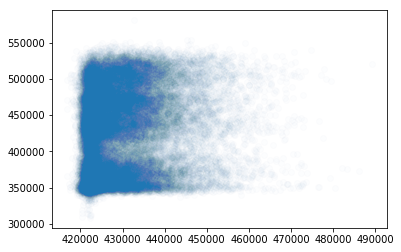

In [19]:
plt.plot(m.predict(X_test), Y_test, 'o', alpha=0.01)
plt.show()

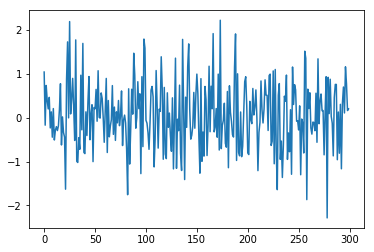

In [24]:
plt.plot(m.coef_.flatten())

## predict logistic

In [33]:
thresh = np.percentile(Y_train, 70)

In [34]:
Y_thresh_train = 1 * (Y_train > thresh)
Y_thresh_test = 1 * (Y_test > thresh)

In [35]:
m = LogisticRegression()
m.fit(X_train, Y_thresh_train)
m.score(X_test, Y_thresh_test)

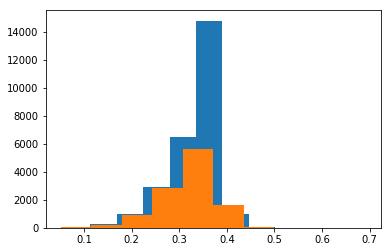

In [39]:
preds = m.predict_proba(X_test)[:, 1:2]
plt.hist(preds[Y_thresh_test==0])
plt.hist(preds[Y_thresh_test==1])
plt.show()
# plt.plot(, Y_thresh_test, 'o', alpha=0.5)

# fit a non-linear model

In [ ]:
net = NeuralNetRegressor(
    MaxLinear(input_dim=300, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-1,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
)

# X = X_flat.astype(np.float32)
# Y = Y_flat.reshape(-1, 1).astype(np.float32)
# X, y = make_classification(1000, 20, n_informative=10, random_state=0)
# X = X.astype(np.float32)
# y = y.astype(np.int64)

net.fit(X_train, Y_train)

In [4]:
ws = net.module_.state_dict()['fc1.weight'].numpy()
plt.plot(ws.T)
plt.show()

(20, 300)


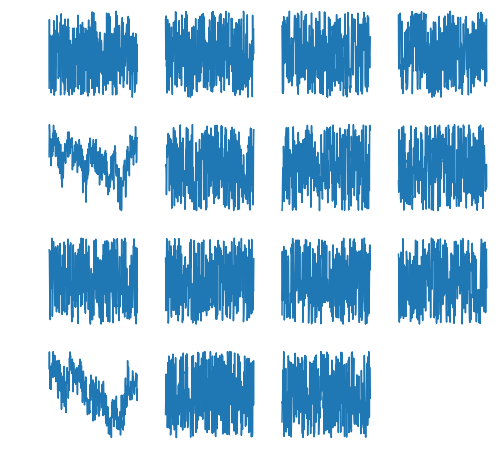

In [35]:
R = 4
C = 4
plt.figure(figsize=(8, 8))
for i in range(1, R * 4):
    plt.subplot(R, C, i)
    plt.plot(ws[i - 1])
    plt.axis('off')

# temporal conv

In [43]:
dirname = 'conv_size=8_num_chanels=8'
# dirname = 'conv_size=8_num_chanels=30' # conv_size x num_conv
# train_end_cp = TrainEndCheckpoint(dirname='exp1')
# net = NeuralNetClassifier(
#     MyModule, lr=0.5, callbacks=[cp, train_end_cp]
# )

net = NeuralNetRegressor(
    models.MaxConv(input_dim=300, num_units=8, kernel_size=8, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-2,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cuda'
)

X_train_expand = np.expand_dims(X_train, 1)

In [44]:
# train
net.fit(X_train_expand, Y_train)
# pkl.dump(net, open( "net_big.pkl", "wb" ))

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        1.5732        1.3065     +  1.0930
      2        1.2886        1.2585     +  1.0197
      3        1.2485        1.2209     +  0.9773
      4        1.2134        1.1883     +  1.0117
      5        1.1819        1.1592     +  0.9790
      6        1.1540        1.1357     +  1.0178
      7        1.1312        1.1174     +  0.9783
      8        1.1141        1.1047     +  1.0407
      9        1.1013        1.0955     +  1.0365
     10        1.0922        1.0894     +  0.9844
     11        1.0858        1.0853     +  1.0338
     12        1.0813        1.0827     +  1.0204
     13        1.0776        1.0805     +  0.9963
     14        1.0749        1.0793     +  1.0188
     15        1.0729        1.0782     +  1.0148
     16        1.0709        1.0768     +  0.9783
     17        1.0690        1.0759     +  1.0283
     18        1.0672        1.0754     +  1.0194


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MaxConv(
    (conv1): Conv1d(1, 8, kernel_size=(8,), stride=(1,), bias=False)
  ),
)

Re-initializing optimizer.
(8, 8)


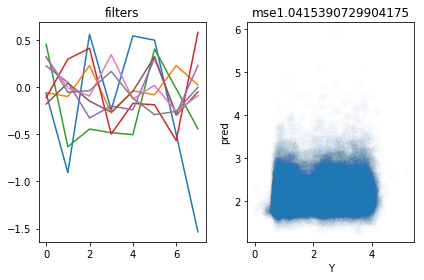

In [46]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 2

ws = net.module_.state_dict()['conv1.weight'].cpu().numpy().squeeze()
print(ws.shape)

plt.subplot(R, C, 1)
plt.title('filters')
plt.plot(ws.T)

plt.subplot(R, C, 2)
preds = net.predict(X_train_expand)
plt.plot(Y_train, preds, 'o', alpha=0.01)
plt.title(f'mse{np.mean(np.square(Y_train - preds)):0.2f} r2')
plt.xlabel('Y')
plt.ylabel('pred')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()

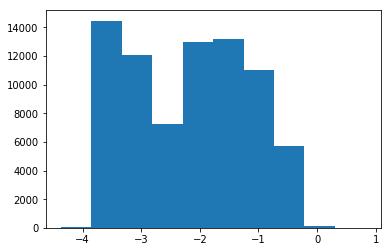

In [41]:
plt.hist(Y_train)
plt.show()